# This file is for programming regist

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click !here goes the icon of the corresponding button in the gutter! button.
To debug a cell, press Alt+Shift+Enter, or click !here goes the icon of the corresponding button in the gutter! button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/jupyter-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

C:\Users\linctex\AppData\Local\Temp\ipykernel_27716\2748049075.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('hsv', num_clusters)


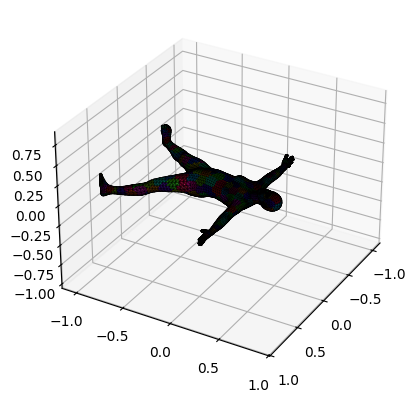

Cluster 0 saved to output_clusters\cluster_0.obj
Extended Cluster 0 saved to output_clusters\extended_cluster_0.obj
Cluster 1 saved to output_clusters\cluster_1.obj
Extended Cluster 1 saved to output_clusters\extended_cluster_1.obj
Cluster 2 saved to output_clusters\cluster_2.obj
Extended Cluster 2 saved to output_clusters\extended_cluster_2.obj
Cluster 3 saved to output_clusters\cluster_3.obj
Extended Cluster 3 saved to output_clusters\extended_cluster_3.obj
Cluster 4 saved to output_clusters\cluster_4.obj
Extended Cluster 4 saved to output_clusters\extended_cluster_4.obj
Cluster 5 saved to output_clusters\cluster_5.obj
Extended Cluster 5 saved to output_clusters\extended_cluster_5.obj
Cluster 6 saved to output_clusters\cluster_6.obj
Extended Cluster 6 saved to output_clusters\extended_cluster_6.obj
Cluster 7 saved to output_clusters\cluster_7.obj
Extended Cluster 7 saved to output_clusters\extended_cluster_7.obj
Cluster 8 saved to output_clusters\cluster_8.obj
Extended Cluster 8 save

In [2]:
import os
import igl
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.cluster import KMeans
from collections import defaultdict
import csv
from hilbertcurve.hilbertcurve import HilbertCurve

# 定义文件路径
input_file = os.path.join("data", "body0.obj")

# 读取 OBJ 文件
V, F = igl.read_triangle_mesh(input_file)

# 使用 KMeans 进行聚类 (假设我们想要 200 个 cluster)
num_clusters = 256
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
face_centers = np.mean(V[F], axis=1)
kmeans.fit(face_centers)
labels = kmeans.labels_

# 找到每个顶点的相邻三角形
vertex_faces = defaultdict(set)
for i, face in enumerate(F):
    for vertex in face:
        vertex_faces[vertex].add(i)

# 计算每个 cluster 的重心
cluster_centroids = []
for i in range(num_clusters):
    cluster_vertices = V[F[labels == i]].reshape(-1, 3)
    centroid = np.mean(cluster_vertices, axis=0)
    cluster_centroids.append(centroid)

cluster_centroids = np.array(cluster_centroids)

# 将重心归一化到 [0, 1] 范围内，然后转换为 [0, 2^p-1] 范围内的整数
p = 10  # 设置Hilbert曲线的阶数
hilbert_max = 2**p - 1
min_coords = np.min(cluster_centroids, axis=0)
max_coords = np.max(cluster_centroids, axis=0)
norm_centroids = (cluster_centroids - min_coords) / (max_coords - min_coords) * hilbert_max
norm_centroids = norm_centroids.astype(int)

# 计算Hilbert编码
hilbert_curve = HilbertCurve(p, 3)
hilbert_indices = [hilbert_curve.distance_from_point(c.tolist()) for c in norm_centroids]
sorted_indices = np.argsort(hilbert_indices)

# 可视化每个 cluster
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.get_cmap('hsv', num_clusters)

for idx in sorted_indices:
    cluster_faces = F[labels == idx]
    cluster_vertices_indices = np.unique(cluster_faces)
    cluster_vertices = V[cluster_vertices_indices]

    new_indices = {old_idx: new_idx for new_idx, old_idx in enumerate(cluster_vertices_indices)}
    cluster_faces_new = np.vectorize(new_indices.get)(cluster_faces)

    patch_mesh = Poly3DCollection(cluster_vertices[cluster_faces_new], alpha=0.5, facecolors=colors(idx))
    patch_mesh.set_edgecolor('k')
    ax.add_collection3d(patch_mesh)

# 设置坐标范围
scale = V.flatten()
ax.auto_scale_xyz(scale, scale, scale)

# 设置视角
ax.view_init(30, 30)

# 显示图形
plt.show()

# 输出目录
output_dir = "output_clusters"
regist_dir = "regist_file"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(regist_dir, exist_ok=True)

# 准备CSV数据
cluster_vertices_list = []
extended_cluster_vertices_list = []

# 将每个 cluster 及其扩展层保存为新的 OBJ 文件
for sorted_idx, idx in enumerate(sorted_indices):
    cluster_faces = F[labels == idx]
    cluster_vertices_indices = np.unique(cluster_faces)
    cluster_vertices = V[cluster_vertices_indices]

    new_indices = {old_idx: new_idx for new_idx, old_idx in enumerate(cluster_vertices_indices)}
    cluster_faces_new = np.vectorize(new_indices.get)(cluster_faces)

    # 保存聚类的原始OBJ
    output_filename = os.path.join(output_dir, f"cluster_{sorted_idx}.obj")
    igl.write_triangle_mesh(output_filename, cluster_vertices, cluster_faces_new)
    print(f"Cluster {sorted_idx} saved to {output_filename}")

    # 保存聚类内的顶点索引到列表
    cluster_vertices_list.append(cluster_vertices_indices)

    # 找到扩展层的三角形
    extended_faces = set()
    for face_idx in np.where(labels == idx)[0]:
        # 找到所有与该face共享顶点的三角形
        for vertex in F[face_idx]:
            extended_faces.update(vertex_faces[vertex])
    extended_faces.difference_update(np.where(labels == idx)[0])  # 移除原始聚类的三角形
    extended_faces = np.array(list(extended_faces))

    if len(extended_faces) > 0:
        extended_cluster_faces = F[extended_faces]
        extended_cluster_vertices_indices = np.unique(extended_cluster_faces)
        extended_cluster_vertices = V[extended_cluster_vertices_indices]

        new_indices_ext = {old_idx: new_idx for new_idx, old_idx in enumerate(extended_cluster_vertices_indices)}
        extended_cluster_faces_new = np.vectorize(new_indices_ext.get)(extended_cluster_faces)

        # 保存扩展层的OBJ
        extended_output_filename = os.path.join(output_dir, f"extended_cluster_{sorted_idx}.obj")
        igl.write_triangle_mesh(extended_output_filename, extended_cluster_vertices, extended_cluster_faces_new)
        print(f"Extended Cluster {sorted_idx} saved to {extended_output_filename}")

        # 保存扩展层顶点索引到列表
        extended_cluster_vertices_list.append(np.unique(np.concatenate((cluster_vertices_indices, extended_cluster_vertices_indices))))
    else:
        print(f"No extended faces found for cluster {sorted_idx}")
        # 如果没有扩展层，则仅保存原始聚类的顶点索引
        extended_cluster_vertices_list.append(cluster_vertices_indices)

# 导出聚类顶点索引的CSV文件
cluster_vertices_file = os.path.join(regist_dir, "cluster_vertices.csv")
with open(cluster_vertices_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for indices in cluster_vertices_list:
        writer.writerow(indices)
print(f"Cluster vertices saved to {cluster_vertices_file}")

# 导出扩展层顶点索引的CSV文件
extended_cluster_vertices_file = os.path.join(regist_dir, "extended_cluster_vertices.csv")
with open(extended_cluster_vertices_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for indices in extended_cluster_vertices_list:
        writer.writerow(indices)
print(f"Extended cluster vertices saved to {extended_cluster_vertices_file}")


In [3]:
def read_skeleton(file_path):
    vertices = []
    edges = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('v '):
                vertices.append([float(x) for x in line.strip().split()[1:]])
            elif line.startswith('l '):
                edges.append([int(x) - 1 for x in line.strip().split()[1:]])  # indices are 1-based in OBJ
    return np.array(vertices), np.array(edges)

# 投影点计算
def project_point_to_segment(p, v, w):
    l2 = np.sum((v - w) ** 2)
    if l2 == 0.0:
        return v
    t = max(0, min(1, np.dot(p - v, w - v) / l2))
    projection = v + t * (w - v)
    return projection

# 计算每个 cluster 的重心
cluster_centroids = []
for i in sorted_indices:
    cluster_vertices = V[F[labels == i]].reshape(-1, 3)
    centroid = np.mean(cluster_vertices, axis=0)
    cluster_centroids.append(centroid)

cluster_centroids = np.array(cluster_centroids)
# 读取骨骼文件
skeleton_file = os.path.join("data", "skeleton0.obj")
skeleton_vertices, skeleton_edges = read_skeleton(skeleton_file)

# 计算每个 cluster 重心到骨骼的最近投影点
projection_points = []
projection_indices = []
for centroid in cluster_centroids:
    min_dist = float('inf')
    nearest_projection = None
    nearest_edge_idx = -1
    for edge_idx, (start_idx, end_idx) in enumerate(skeleton_edges):
        start_vertex = skeleton_vertices[start_idx]
        end_vertex = skeleton_vertices[end_idx]
        projection = project_point_to_segment(centroid, start_vertex, end_vertex)
        dist = np.linalg.norm(centroid - projection)
        if dist < min_dist:
            min_dist = dist
            nearest_projection = projection
            nearest_edge_idx = edge_idx
    projection_points.append(nearest_projection)
    projection_indices.append(nearest_edge_idx)

# 输出 CSV 文件
output_csv_file = os.path.join(regist_dir, "projections.csv")
with open(output_csv_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for idx, (proj_point, proj_idx) in enumerate(zip(projection_points, projection_indices)):
        writer.writerow([proj_idx, *proj_point])
print(f"Projections saved to {output_csv_file}")

# 生成连接重心和投影点的 OBJ 文件
output_obj_file = os.path.join(regist_dir, "centroids_to_projections.obj")
with open(output_obj_file, 'w') as f:
    for i, (centroid, projection) in enumerate(zip(cluster_centroids, projection_points)):
        f.write(f"v {centroid[0]} {centroid[1]} {centroid[2]}\n")
        f.write(f"v {projection[0]} {projection[1]} {projection[2]}\n")
    for i in range(len(cluster_centroids)):
        f.write(f"l {2*i+1} {2*i+2}\n")
print(f"Connections saved to {output_obj_file}")

Projections saved to regist_file\projections.csv
Connections saved to regist_file\centroids_to_projections.obj


In [4]:
import os
import igl
import numpy as np
from sklearn.cluster import KMeans
from collections import defaultdict
import csv

# 读取骨骼文件
def read_skeleton(file_path):
    vertices = []
    edges = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('v '):
                vertices.append([float(x) for x in line.strip().split()[1:]])
            elif line.startswith('l '):
                edges.append([int(x) - 1 for x in line.strip().split()[1:]])  # indices are 1-based in OBJ
    return np.array(vertices), np.array(edges)

# 投影点计算
def project_point_to_segment(p, v, w):
    l2 = np.sum((v - w) ** 2)
    if l2 == 0.0:
        return v
    t = max(0, min(1, np.dot(p - v, w - v) / l2))
    projection = v + t * (w - v)
    return projection

# 计算AABB的8个角顶点
def compute_aabb(vertices):
    min_corner = np.min(vertices, axis=0)
    max_corner = np.max(vertices, axis=0)
    return np.array([
        [min_corner[0], min_corner[1], min_corner[2]],
        [min_corner[0], min_corner[1], max_corner[2]],
        [min_corner[0], max_corner[1], min_corner[2]],
        [min_corner[0], max_corner[1], max_corner[2]],
        [max_corner[0], min_corner[1], min_corner[2]],
        [max_corner[0], min_corner[1], max_corner[2]],
        [max_corner[0], max_corner[1], min_corner[2]],
        [max_corner[0], max_corner[1], max_corner[2]]
    ])

# 计算每个 cluster 的 AABB
aabb_corners = []
for i in sorted_indices:
    cluster_vertices = V[F[labels == i]].reshape(-1, 3)
    corners = compute_aabb(cluster_vertices)
    aabb_corners.append(corners)

# 读取骨骼文件
skeleton_file = os.path.join("data", "skeleton0.obj")
skeleton_vertices, skeleton_edges = read_skeleton(skeleton_file)

# 计算每个 AABB 角顶点到骨骼的最近投影点
projection_points = []
projection_indices = []
cluster_to_bone_map = defaultdict(set)
bone_to_cluster_map = defaultdict(set)
for cluster_idx, corners in enumerate(aabb_corners):
    cluster_proj_points = []
    for corner in corners:
        min_dist = float('inf')
        nearest_projection = None
        nearest_edge_idx = -1
        for edge_idx, (start_idx, end_idx) in enumerate(skeleton_edges):
            start_vertex = skeleton_vertices[start_idx]
            end_vertex = skeleton_vertices[end_idx]
            projection = project_point_to_segment(corner, start_vertex, end_vertex)
            dist = np.linalg.norm(corner - projection)
            if dist < min_dist:
                min_dist = dist
                nearest_projection = projection
                nearest_edge_idx = edge_idx
        cluster_proj_points.append(nearest_projection)
        cluster_to_bone_map[cluster_idx].add(nearest_edge_idx)
        bone_to_cluster_map[nearest_edge_idx].add(cluster_idx)
    projection_points.append(cluster_proj_points)
    projection_indices.append([nearest_edge_idx for _ in corners])

# 输出 AABB 和投影点的 OBJ 文件
output_obj_file = os.path.join(regist_dir, "aabb_projections.obj")
with open(output_obj_file, 'w') as f:
    vertex_idx = 1
    for cluster_idx, (corners, proj_points) in enumerate(zip(aabb_corners, projection_points)):
        corner_indices = []
        proj_indices = []
        for corner in corners:
            f.write(f"v {corner[0]} {corner[1]} {corner[2]}\n")
            corner_indices.append(vertex_idx)
            vertex_idx += 1
        for proj_point in proj_points:
            f.write(f"v {proj_point[0]} {proj_point[1]} {proj_point[2]}\n")
            proj_indices.append(vertex_idx)
            vertex_idx += 1
        # 写入AABB的12条边
        edges = [
            (0, 1), (1, 3), (3, 2), (2, 0),  # Bottom face
            (4, 5), (5, 7), (7, 6), (6, 4),  # Top face
            (0, 4), (1, 5), (2, 6), (3, 7)   # Side edges
        ]
        for edge in edges:
            f.write(f"l {corner_indices[edge[0]]} {corner_indices[edge[1]]}\n")
        # 写入角点到投影点的连线
        for i in range(len(corners)):
            f.write(f"l {corner_indices[i]} {proj_indices[i]}\n")
            
print(f"AABB and projections saved to {output_obj_file}")

# 输出 CSV 文件
cluster_to_bone_csv = os.path.join(regist_dir, "cluster_to_bone.csv")
with open(cluster_to_bone_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for cluster_idx in range(num_clusters):
        writer.writerow([cluster_idx] + list(cluster_to_bone_map[cluster_idx]))
print(f"Cluster to bone map saved to {cluster_to_bone_csv}")

bone_to_cluster_csv = os.path.join(regist_dir, "bone_to_cluster.csv")
with open(bone_to_cluster_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for bone_idx in range(len(skeleton_edges)):
        writer.writerow([bone_idx] + list(bone_to_cluster_map[bone_idx]))
print(f"Bone to cluster map saved to {bone_to_cluster_csv}")


AABB and projections saved to regist_file\aabb_projections.obj
Cluster to bone map saved to regist_file\cluster_to_bone.csv
Bone to cluster map saved to regist_file\bone_to_cluster.csv


In [5]:
def clusters_adjacent(cluster1, cluster2):
    common_vertices = set(cluster1).intersection(set(cluster2))
    return len(common_vertices) > 0

# 计算并输出邻接关系 CSV 文件
neighbor_csv = os.path.join(regist_dir, "cluster_neighbor.csv")
neighbors = defaultdict(list)

for i in range(num_clusters):
    for j in range(i + 1, num_clusters):
        if clusters_adjacent(cluster_vertices_list[i], cluster_vertices_list[j]):
            neighbors[i].append(j)
            neighbors[j].append(i)

with open(neighbor_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for cluster_idx in range(num_clusters):
        writer.writerow([cluster_idx] + neighbors[cluster_idx])
print(f"Cluster neighbors saved to {neighbor_csv}")

Cluster neighbors saved to regist_file\cluster_neighbor.csv


In [9]:
# 计算每个 extended_cluster 内的所有顶点在骨骼段上的最近投影点
cluster_to_bone_map = defaultdict(set)
bone_to_cluster_map = defaultdict(set)

for cluster_idx, extended_cluster_vertices_indices in enumerate(extended_cluster_vertices_list):
    for vertex_idx in extended_cluster_vertices_indices:
        vertex = V[vertex_idx]
        min_dist = float('inf')
        nearest_edge_idx = -1
        for edge_idx, (start_idx, end_idx) in enumerate(skeleton_edges):
            start_vertex = skeleton_vertices[start_idx]
            end_vertex = skeleton_vertices[end_idx]
            projection = project_point_to_segment(vertex, start_vertex, end_vertex)
            dist = np.linalg.norm(vertex - projection)
            if dist < min_dist:
                min_dist = dist
                nearest_edge_idx = edge_idx
        cluster_to_bone_map[cluster_idx].add(nearest_edge_idx)
        bone_to_cluster_map[nearest_edge_idx].add(cluster_idx)

# 输出 CSV 文件
cluster_to_bone_csv = os.path.join("regist_file", "cluster_to_bone_all.csv")
with open(cluster_to_bone_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for cluster_idx in range(num_clusters):
        writer.writerow([cluster_idx] + list(cluster_to_bone_map[cluster_idx]))
print(f"Cluster to bone map saved to {cluster_to_bone_csv}")

bone_to_cluster_csv = os.path.join("regist_file", "bone_to_cluster_all.csv")
with open(bone_to_cluster_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for bone_idx in range(len(skeleton_edges)):
        writer.writerow([bone_idx] + list(bone_to_cluster_map[bone_idx]))
print(f"Bone to cluster map saved to {bone_to_cluster_csv}")

Cluster to bone map saved to regist_file\cluster_to_bone_all.csv
Bone to cluster map saved to regist_file\bone_to_cluster_all.csv


In [ ]:
import os
import igl
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.cluster import KMeans
from collections import defaultdict
import csv

# 定义文件路径
input_file = os.path.join("data", "plane5mm.obj")

# 读取 OBJ 文件
V, F = igl.read_triangle_mesh(input_file)

# 使用 KMeans 进行聚类 (假设我们想要 200 个 cluster)
num_clusters = 24
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
face_centers = np.mean(V[F], axis=1)
kmeans.fit(face_centers)
labels = kmeans.labels_

# 找到每个顶点的相邻三角形
vertex_faces = defaultdict(set)
for i, face in enumerate(F):
    for vertex in face:
        vertex_faces[vertex].add(i)

# 计算每个 cluster 的重心
cluster_centroids = []
for i in range(num_clusters):
    cluster_vertices = V[F[labels == i]].reshape(-1, 3)
    centroid = np.mean(cluster_vertices, axis=0)
    cluster_centroids.append(centroid)

cluster_centroids = np.array(cluster_centroids)

# 计算 Morton 编码
def interleave_bits(x, y, z):
    def split_by_3(x):
        x = (x | (x << 16)) & 0x030000FF
        x = (x | (x << 8)) & 0x0300F00F
        x = (x | (x << 4)) & 0x030C30C3
        x = (x | (x << 2)) & 0x09249249
        return x
    return split_by_3(x) | (split_by_3(y) << 1) | (split_by_3(z) << 2)

morton_codes = [interleave_bits(int(c[0]*1024), int(c[1]*1024), int(c[2]*1024)) for c in cluster_centroids]
sorted_indices = np.argsort(morton_codes)

# 输出目录
output_dir = "output_clusters"
os.makedirs(output_dir, exist_ok=True)

# 准备CSV数据
cluster_vertices_list = []
extended_cluster_vertices_list = []

# 将每个 cluster 及其扩展层保存为新的 OBJ 文件
for sorted_idx, idx in enumerate(sorted_indices):
    cluster_faces = F[labels == idx]
    cluster_vertices_indices = np.unique(cluster_faces)
    cluster_vertices = V[cluster_vertices_indices]

    new_indices = {old_idx: new_idx for new_idx, old_idx in enumerate(cluster_vertices_indices)}
    cluster_faces_new = np.vectorize(new_indices.get)(cluster_faces)

    # 保存聚类的原始OBJ
    output_filename = os.path.join(output_dir, f"cluster_{sorted_idx}.obj")
    igl.write_triangle_mesh(output_filename, cluster_vertices, cluster_faces_new)
    print(f"Cluster {sorted_idx} saved to {output_filename}")

    # 保存聚类内的顶点索引到列表
    cluster_vertices_list.append(cluster_vertices_indices)

    # 找到扩展层的三角形
    extended_faces = set()
    for face_idx in np.where(labels == idx)[0]:
        # 找到所有与该face共享顶点的三角形
        for vertex in F[face_idx]:
            extended_faces.update(vertex_faces[vertex])
    extended_faces.difference_update(np.where(labels == idx)[0])  # 移除原始聚类的三角形
    extended_faces = np.array(list(extended_faces))

    if len(extended_faces) > 0:
        extended_cluster_faces = F[extended_faces]
        extended_cluster_vertices_indices = np.unique(extended_cluster_faces)
        extended_cluster_vertices = V[extended_cluster_vertices_indices]

        new_indices_ext = {old_idx: new_idx for new_idx, old_idx in enumerate(extended_cluster_vertices_indices)}
        extended_cluster_faces_new = np.vectorize(new_indices_ext.get)(extended_cluster_faces)

        # 保存扩展层的OBJ
        extended_output_filename = os.path.join(output_dir, f"extended_cluster_{sorted_idx}.obj")
        igl.write_triangle_mesh(extended_output_filename, extended_cluster_vertices, extended_cluster_faces_new)
        print(f"Extended Cluster {sorted_idx} saved to {extended_output_filename}")

        # 保存扩展层顶点索引到列表
        extended_cluster_vertices_list.append(np.unique(np.concatenate((cluster_vertices_indices, extended_cluster_vertices_indices))))
    else:
        print(f"No extended faces found for cluster {sorted_idx}")
        # 如果没有扩展层，则仅保存原始聚类的顶点索引
        extended_cluster_vertices_list.append(cluster_vertices_indices)

# 导出聚类顶点索引的CSV文件
cluster_vertices_file = os.path.join(output_dir, "cluster_vertices.csv")
with open(cluster_vertices_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for indices in cluster_vertices_list:
        writer.writerow(indices)
print(f"Cluster vertices saved to {cluster_vertices_file}")

# 导出扩展层顶点索引的CSV文件
extended_cluster_vertices_file = os.path.join(output_dir, "extended_cluster_vertices.csv")
with open(extended_cluster_vertices_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for indices in extended_cluster_vertices_list:
        writer.writerow(indices)
print(f"Extended cluster vertices saved to {extended_cluster_vertices_file}")
